In [56]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path

# test_data_root = os.environ["DALI_EXTRA_PATH"]
# db_folder = os.path.join(test_data_root, "db", "lmdb")

In [57]:
def random_transform():
    dst_cx, dst_cy = (200, 200)
    src_cx, src_cy = (200, 200)

    # This function uses homogeneous coordinates - hence, 3x3 matrix

    # translate output coordinates to center defined by (dst_cx, dst_cy)
    t1 = np.array([[1, 0, -dst_cx], [0, 1, -dst_cy], [0, 0, 1]])

    def u():
        return np.random.uniform(-0.5, 0.5)

    # apply a randomized affine transform - uniform scaling + some random
    # distortion
    m = np.array([[1 + u(), u(), 0], [u(), 1 + u(), 0], [0, 0, 1]])

    # translate input coordinates to center (src_cx, src_cy)
    t2 = np.array([[1, 0, src_cx], [0, 1, src_cy], [0, 0, 1]])

    # combine the transforms
    m = np.matmul(t2, np.matmul(m, t1))

    # remove the last row; it's not used by affine transform
    return m[0:2, 0:3].astype(np.float32)


np.random.seed(seed=123)

In [ ]:
import nvidia.dali as dali
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import numpy as np
import nvidia.dali.fn as fn
import nvidia.dali.types as types

batch_size=1
pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
input, _ = fn.file_reader(file_root="/hdd1t/mduc/ocr/lib_ocr/experiment/img", shard_id=0, num_shards=1)
transform = fn.external_source(
    batch=False, source=random_transform, dtype=types.FLOAT
)
decoded_cpu = fn.image_decoder(input, output_type=types.RGB, device="cpu")

images = fn.resize(decoded_cpu, resize_y=100, dtype=types.FLOAT)

# TODO: Figure out the hyperparameters in augementation setting
# Apply brightness and contrast adjustment
images_brigtness = fn.brightness_contrast(images,
                                brightness=0.2,  # Brightness adjustment factor
                                contrast=0.2)    # Contrast adjustment factor

# Apply HSV color space adjustment
images_hsv = fn.hsv(images,
                hue=0.1,        # Hue adjustment
                saturation=0.2, # Saturation adjustment
                value=0.1)      # Value adjustment

# TODO: Use a better affine matrix
# Apply affine transformation
images_affine = fn.warp_affine(images,
                        matrix=[1.0, 0.1, 0.0, 0.1, 1.0, 0.0],  # 2x3 affine transformation matrix
                        fill_value=0,
                        interp_type=types.INTERP_NN)

# warped_gpu = fn.warp_affine(
#     decoded_cpu,
#     transform,  # pass the transform parameters through GPU memory
#     size=(400, 400),  # specify the output size
#     # fill_value,       # not specifying `fill_value`
#     #  results in source coordinate clamping
#     interp_type=types.INTERP_LINEAR,
# )  # use linear interpolation

# warped_cpu = fn.warp_affine(
#     decoded_cpu,
#     matrix=transform,  # pass the transform through a named input
#     fill_value=200,
#     size=(400, 400),  # specify the output size
#     interp_type=types.INTERP_NN,
# )  # use nearest neighbor interpolation

# warped_keep_size = fn.warp_affine(
#     decoded_cpu,
#     transform,
#     # size,        # keep the original canvas size
#     interp_type=types.INTERP_LINEAR,
# )  # use linear interpolation
pipe.set_outputs(images, images_brigtness, images_hsv, images_affine)
pipe.build()
# for _ in range(3):
#     out = pipe.run()
#     print(out[0].as_array(), out[1].as_cpu().as_array())
#     print("*"*50)

/hdd1t/mduc/.conda/envs/ocr/lib/python3.11/site-packages/nvidia/dali/ops/__init__.py:398: DeprecationWarning: WARNING: `nvidia.dali.fn.file_reader` is now deprecated. Use `nvidia.dali.fn.readers.file` instead.
In DALI 1.0 all readers were moved into a dedicated :mod:`~nvidia.dali.fn.readers`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  _handle_op_deprecation(
/hdd1t/mduc/.conda/envs/ocr/lib/python3.11/site-packages/nvidia/dali/ops/__init__.py:398: DeprecationWarning: WARNING: `nvidia.dali.fn.image_decoder` is now deprecated. Use `nvidia.dali.fn.decoders.image` instead.
In DALI 1.0 all decoders were moved into a dedicated :mod:`~nvidia.dali.fn.decoders`
submodule and renamed to follow a common pattern. This is a placeholder operator with identical
functionality to allow for backward compatibility.
  _handle_op_deprecation(


In [59]:
pipe_out = pipe.run()

Affine transform matrix:
[[[9.040001  9.040001  9.040001 ]
  [8.900001  8.900001  8.900001 ]
  [8.810401  8.810401  8.810401 ]
  ...
  [9.507991  9.507991  9.507991 ]
  [9.520005  9.520005  9.520005 ]
  [9.56      9.56      9.56     ]]

 [[9.132001  9.132001  9.132001 ]
  [9.001201  9.001201  9.001201 ]
  [8.913073  8.913073  8.913073 ]
  ...
  [9.281293  9.281293  9.281293 ]
  [9.262405  9.262405  9.262405 ]
  [9.302401  9.302401  9.302401 ]]

 [[9.284     9.284     9.284    ]
  [9.1640005 9.1640005 9.1640005]
  [9.077041  9.077041  9.077041 ]
  ...
  [9.049408  9.049408  9.049408 ]
  [8.992005  8.992005  8.992005 ]
  [9.032001  9.032001  9.032001 ]]

 ...

 [[9.548001  9.548001  9.548001 ]
  [9.394001  9.394001  9.394001 ]
  [9.154321  9.154321  9.154321 ]
  ...
  [9.211469  9.211469  9.211469 ]
  [9.302002  9.302002  9.302002 ]
  [9.3080015 9.3080015 9.3080015]]

 [[9.304002  9.304002  9.304002 ]
  [9.122401  9.122401  9.122401 ]
  [8.916834  8.916834  8.916834 ]
  ...
  [9.136845  

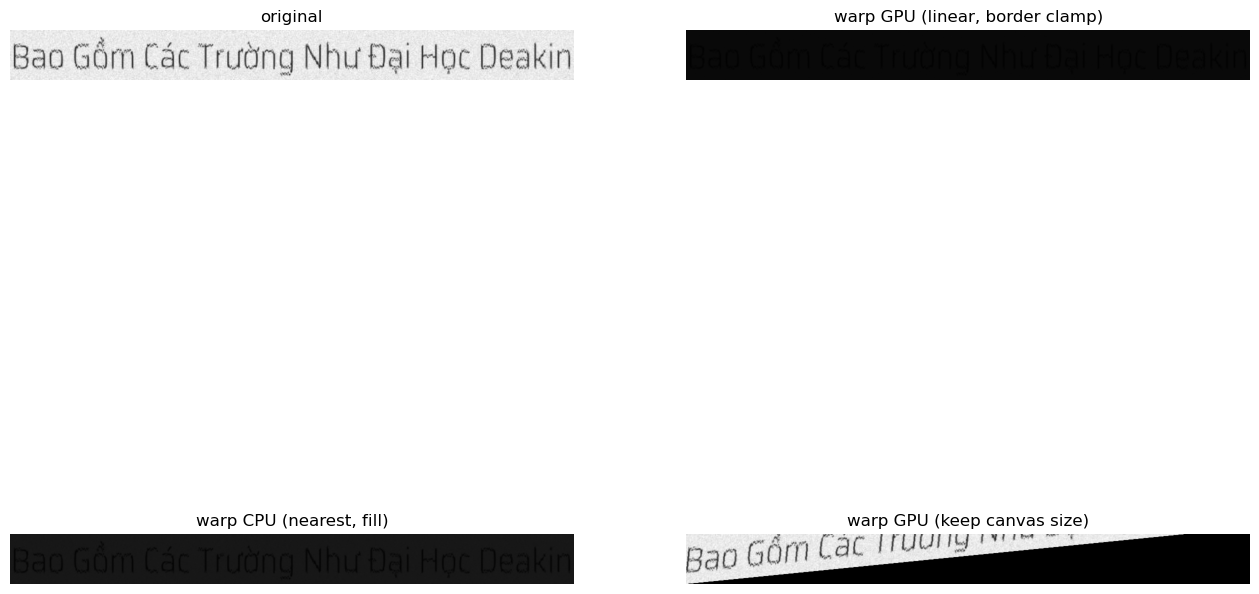

In [60]:
n = 0  # change this value to see other images from the batch;
# it must be in 0..batch_size-1 range

# from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec

len_outputs = len(pipe_out)

captions = [
    "original",
    "warp GPU (linear, border clamp)",
    "warp CPU (nearest, fill)",
    "warp GPU (keep canvas size)",
]

fig = plt.figure(figsize=(16, 12))
# plt.suptitle(imagenet_synsets[pipe_out[0].at(n)[0]], fontsize=16)
columns = 2
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)

print("Affine transform matrix:")
print(pipe_out[1].at(n))

for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(captions[i])
    pipe_out_cpu = pipe_out[0 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow((img_chw) / 255.0)